The process of calculating the causal factors from the observation is called [inverse problem](https://en.wikipedia.org/wiki/Inverse_problem). An inverse problem is much harder to solve than the corresponding forward counterpart, which is calculating the observation from the causal factors.  
<img src="https://github.com/arturmiller/MachineLearning/blob/master/notebooks/images/inverse_problem.png?raw=true" style="width: 50%;"/>  
Many problems in science and math are inverse problems. They can be found in optics, radar, acoustics, communication theory, signal processing, medical imaging, computer vision, geophysics, oceanography, astronomy, remote sensing, natural language processing, machine learning, nondestructive testing, and many other fields.  
Two concrete examples are image deblurring and computer vision. Computer vision is the inverse problem of computer graphics and image deblurring is the inverse problem of image convolution. I have already covert the topic of image deblurring in previous posts ([part 1](https://miller-blog.com/image-deblurring/) and [part 2](https://miller-blog.com/image-deblurring-part-2/)).  
Inverse problems are hard, because
- they are often underdetermined. That means they have no unique solution.
- There exist no direct inversion of the forward problem,
- and they are Ill-posed, so small observation errors cause high inversion errors.

Inverse problems are often solved iteratively. For example for a given $y$, we could try out different $x$ and evaluate $f(x)$. If $y$ is equal to $f(x)$, we know $x$ is a valid solution. This technique might take very long (infinitely  long if $x$ is continuous) to find the correct result. A better procedure is to describe this problem as an optimization problem and solve it with gradient descent (or other gradient based algorithms). For that we need a loss function:  
$$L=(y-f(x))^2$$  
Minimizing this loss function gives us the right result.  
$$x^\star=\underset{x}{\operatorname{argmin}}(L)$$  
If $f(x)$ is differentiable and the loss function is convex, this problem can be solved with gradient descent, by iteratively calculating the next best solution with:  
$$x_{n+1}=x_n-\alpha\frac{dL}{dx}$$

Lets define a small inverse problem, with the function
$$f(x)=2x-4.$$
We search for $f^{-1}(0)$. This example is not particularly hard, since you could solve it analytically. However it is a good example that shows the optimization procedure.

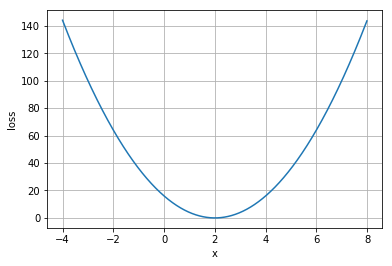

In [51]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

def f(x, a=2, b=-4):
    return a*x + b

def L(y, x, a=2, b=-4):
    return (y - f(x, a, b))**2

gt_x = np.arange(-4, 8, 0.01)
gt_loss = L(0.0, gt_x)
plt.plot(gt_x, gt_loss)
plt.xlabel('x')
plt.ylabel('loss')
plt.grid()

Solving this optimization problem with gradient descent requires differentiating the loss function. It would be possible to solve many optimization problems without a gradient, using evolutionary algorithms or estimating the gradient in a different way. If gradients are available you should use them, because they significantly simplify and accelerate the problem.

In [52]:
def df(x, a, b):
    return a

def dL(y, x, a=2, b=-4):
    return -2 * (y - f(x, a, b)) * df(x, a, b)

Solving our exemplary optimization problem with gradient descent and properly selected $\alpha$, leads to the correct result $1.97\approx2=f^{-1}(0)$. For this example we can verify the result analytically:
$$f^{-1}(y)=\frac{y+4}{2}\\
f^{-1}(0)=2$$

Prediction:
$$h_{\theta}(y)=g(N, y)= x_{N}\approx f^{-1}(y)=\underset{x}{\operatorname{argmin}}(L(x, y)) $$
Training:
$$\theta=\underset{\theta}{\operatorname{argmin}}(T(x, y))\\
T(x, y)=\sum_i{(x_i-h(y_i))^2}\\
f(y)=\theta_1 y + \theta_2\\
\theta_{n+1}=\theta_{n+1}-\beta\frac{dT}{d\theta}\\
\frac{dT}{d\theta}=-2\sum_i (x-h_{\theta}(y))\frac{dh_{\theta}(y)}{d\theta}\\
\frac{dh_{\theta}(y)}{d\theta}=\frac{dg_{\theta}(N, y)}{d\theta}\\
\frac{dg_{\theta}(n, y)}{d\theta}=\frac{dg_{\theta}(n-1,y)}{\theta}-\alpha \frac{d}{d\theta}\frac{d}{dx}(L_\theta)\\
\frac{d}{d\theta}\frac{d}{dx}(L_\theta)=2\left(
\begin{array}{c}
-y+2\theta_1 x+\theta_1^2\frac{dx}{d\theta_1}+\theta_2\\
\theta_1^2\frac{dx}{d\theta_2}+\theta_1\\
\end{array}
\right)$$


x_opt=1.97


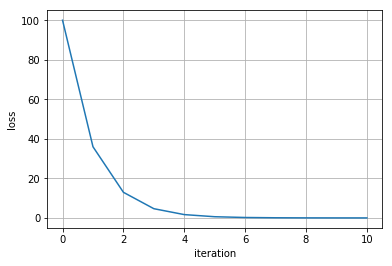

In [53]:
alpha = 0.05
current_x_opt = -3.0
current_loss = L(0.0, current_x_opt)
x_opt = [current_x_opt,]
loss = [current_loss,]

def g(n, y, a=2, b=-4):
    if n == 0:
        gn = -3.0
    else:
        gn1 = g(n-1, y, a, b)
        gn = gn1 - alpha * dL(y, gn1, a, b)

        current_loss = L(0.0, gn)
        x_opt.append(gn)
        loss.append(current_loss)
    
    return gn

from functools import partial
h = partial(g, 10)

current_x_opt = h(0.0)   

print('x_opt={0:.2f}'.format(current_x_opt))
plt.plot(loss)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('loss')

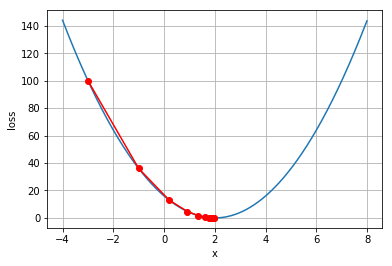

In [54]:
plt.plot(gt_x, gt_loss)
plt.plot(x_opt, loss, 'o-', color='red')
plt.xlabel('x')
plt.ylabel('loss')
plt.grid()

In [55]:
def T(a, b, x, y):
    return np.sum((x - h(y, a, b))**2)

def dga(n, y, a, b):
    if n == 0:
        return 0.0
    else:
        g_res = g(n-1, y, a, b)
        dga_res = dga(n-1, y, a, b)
        return dga_res - alpha * 2 * (-y + 2*a*g_res + a**2*dga_res + b)

def dgb(n, y, a, b):
    if n == 0:
        return 0.0
    else:
        dgb_res = dgb(n-1, y, a, b)
        return dgb_res - alpha * 2 * (a**2*dgb_res + a)

def dha(y, a, b):
    return dga(10, y, a, b)

def dhb(y, a, b):
    return dgb(10, y, a, b)

def dTa(a, b, x, y):
    return -2*np.sum((x - h(y, a, b))*dha(y, a, b))

def dTb(a, b, x, y):
    return -2*np.sum((x - h(y, a, b))*dhb(y, a, b))


a: 1.902161009501768
b: -4.154501313146307


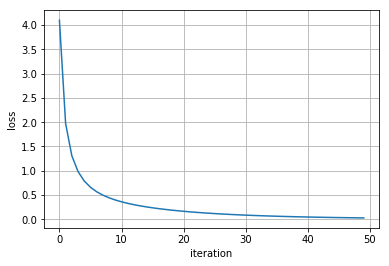

In [62]:
current_a_opt = 0.5
current_b_opt = -4.0
x = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
y = f(x)
beta = 0.01
loss_T = []

for i in range(50):
    tmp_a_opt = current_a_opt - beta * dTa(current_a_opt, current_b_opt, x, y)
    tmp_b_opt = current_b_opt - beta * dTb(current_a_opt, current_b_opt, x, y)
    current_a_opt = tmp_a_opt
    current_b_opt = tmp_b_opt

    current_loss = T(current_a_opt, current_b_opt, x, y)
    loss_T.append(current_loss)

print('a: ' + str(current_a_opt))
print('b: ' + str(current_b_opt))

plt.plot(loss_T)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('loss')

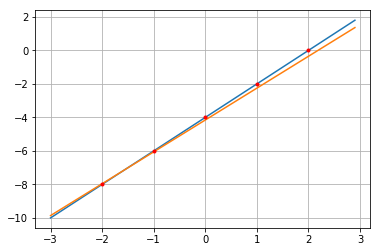

In [64]:
x_plot = np.arange(-3.0, 3.0, 0.1)
y_pred = f(x_plot, current_a_opt, current_b_opt)
y_gt = f(x_plot)
plt.plot(x_plot, y_gt)
plt.plot(x_plot, y_pred)
plt.plot(x, y, '.', color='red')
plt.grid()